In [142]:
#Basic libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Drop future warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as smpipe
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [102]:
recession_vs_yield = pd.read_csv('data/preprocessed_2.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))


#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
data_split = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_split = data_split.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_split, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

In [103]:
#sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon']), hue = 'USREC', plot_kws={'alpha': 0.25});

In [104]:
#Set the global X and y variables
X = data.drop(columns = ['USREC'])
y = data['USREC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [146]:
#Logistic regression model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', LogisticRegression(max_iter=9000))]
lr_pipe = smpipe(steps = steps)
lr_grid = [{'rgsr__C': [1e4,1e6], 'rgsr__solver': ['newton-cg', "lbfgs", 'liblinear', 'sag', 'saga']}]
lr_grid_search = GridSearchCV(estimator = lr_pipe, param_grid = lr_grid,cv = 5, scoring = 'recall')

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': [50,60,70,80], 'rgsr__max_depth': [2,3,4,5], 'rgsr__min_samples_leaf': [1,2,3,4]}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall')

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', GradientBoostingClassifier())]
xg_pipe = smpipe(steps = steps)
xg_grid = [{'rgsr__n_estimators': [50,100,200,400]}]
xg_grid_search = GridSearchCV(estimator = xg_pipe, param_grid = xg_grid, cv = 5, scoring = 'f1')

#Fit the models
lr_grid_search.fit(X_train,y_train)
rf_grid_search.fit(X_train,y_train)
xg_grid_search.fit(X_train,y_train)

#Report accuracy
print('Logistic regression recall: ', recall_score(y_test,lr_grid_search.predict(X_test)))
print('Random forest regression recall: ', recall_score(y_test,rf_grid_search.predict(X_test)))
print('XGBoost regression recall: ', recall_score(y_test,xg_grid_search.predict(X_test)))

Logistic regression recall:  0.6666666666666666
Random forest regression recall:  0.8888888888888888
XGBoost regression recall:  0.7777777777777778


Area under the curve logistic regression:  0.7884
Area under the curve random forest:  0.8616
Area under the curve XGBoost:  0.8448


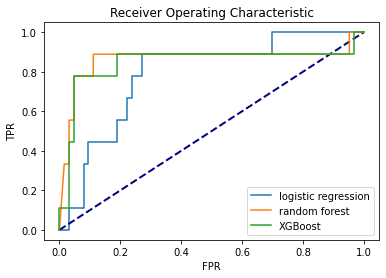

In [147]:
#For the logistic regression ROC
fpr, tpr, thresholds = roc_curve(y_test, lr_grid_search.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr, label = 'logistic regression')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve logistic regression: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'random forest')
aucscore = auc(fpr,tpr)
print('Area under the curve random forest: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, xg_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'XGBoost')
aucscore = auc(fpr,tpr)
print('Area under the curve XGBoost: ',round(aucscore,4))

plt.legend(loc = 'best');

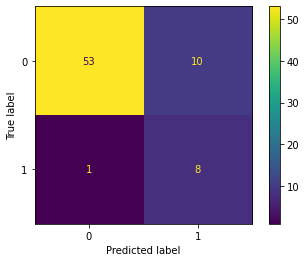

In [154]:
threshold = 0.58
y_probas = rf_grid_search.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > threshold else 0 for y in y_probas]
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test))
disp = ConfusionMatrixDisplay(conf)
disp.plot();

In [140]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)
report;

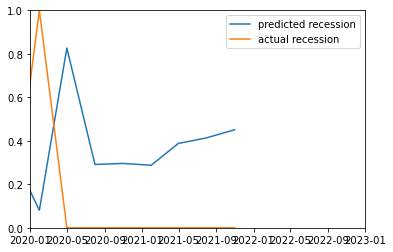

In [141]:
from datetime import datetime as dt
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')

plt.axis([dt.fromisoformat('2020-01-01'), dt.fromisoformat('2023-01-01'), 0, 1]);